# Regularization: Regressão LASSO e Ridge

Objetivo: Avaliar a base de dados *"Boston House Prices"* utilizando os métodos LASSO e Ridge e comparar o resultado com o modelo tradicional de regressão linear.

## 1. Carregando Base dados

In [45]:
# ## Carga inicial
# Será utilizada a biblioteca [scikit-learn](http://scikit-learn.org/) para o trabalho.
# A partir da biblioteca, é possível carregar diretamente os dados que serão utilizados. 
#Esses dados serão carregados em um DataFrame para facilitar a visualização e a manipulação.

# In[1]:
from sklearn.datasets import load_boston

boston = load_boston()
#print(boston.DESCR)


In [46]:
# In[2]:
import pandas as pd
boston_df = pd.DataFrame(boston.data)
boston_df.columns = boston.feature_names
boston_df['Price'] = boston.target

pd.options.display.float_format = '{:,.3g}'.format # Just Format!
boston_df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18,2.31,0,0.538,6.58,65.2,4.09,1,296,15.3,397,4.98,24
1,0.0273,0,7.07,0,0.469,6.42,78.9,4.97,2,242,17.8,397,9.14,21.6
2,0.0273,0,7.07,0,0.469,7.18,61.1,4.97,2,242,17.8,393,4.03,34.7
3,0.0324,0,2.18,0,0.458,7,45.8,6.06,3,222,18.7,395,2.94,33.4
4,0.0691,0,2.18,0,0.458,7.15,54.2,6.06,3,222,18.7,397,5.33,36.2


## 2. Regressão Linear

A regressão linear será realizada utilizando o método dos mínimos quadrados.

### 2.1 Linear: Ajustando o Modelo

In [47]:
# In[3]:
from sklearn.linear_model import LinearRegression
import numpy as np

lr = LinearRegression()

_x = boston_df.drop('Price', axis=1)
y = boston_df['Price']

# Normalizando as variáveis input
mu = np.mean(_x, axis=0)
sigma = np.std(_x, axis=0)
x = (_x - mu) / sigma

lr.fit(x, y)

# Apresentamos abaixo os coeficientes calculados.
coef_df = pd.DataFrame(index=np.append(['Intercept'], boston.feature_names))
coef_df['OLS'] = np.append([lr.intercept_], lr.coef_) 
coef_df.T

,Intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
OLS,22.5,-0.92,1.08,0.143,0.682,-2.06,2.67,0.0211,-3.1,2.66,-2.08,-2.06,0.857,-3.75


### 2.2 Linear: Calculando estatística de ajuste

In [48]:
# In[4]:
from sklearn.metrics import mean_squared_error, r2_score

mse_ls = mean_squared_error(y, lr.predict(x))
r2_ls = r2_score(y, lr.predict(x))

#Colocando as estatisticas de ajuste MSE e R^2 em tabela
result_df = pd.DataFrame(index=['MSE', 'R\u00b2'])
result_df['OLS'] = [mse_ls, r2_ls]
result_df

,OLS
MSE,21.9
R²,0.741


### 2.3 Linear: Gráfico Real X Previsto

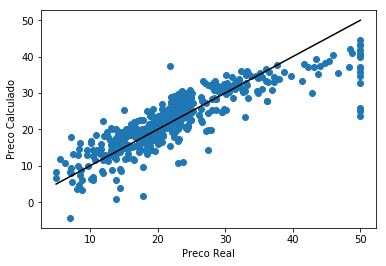

In [49]:
# ... e o gráfico com a diferença entre o preço real e o calculado.
# In[5]:
import matplotlib.pyplot as plt
#get_ipython().magic('matplotlib inline')

def scatterPlot(actual, predicted):
    plt.scatter(actual, predicted)
    range = [actual.min(), actual.max()]
    plt.plot(range, range, 'black')
    plt.xlabel("Preco Real")
    plt.ylabel("Preco Calculado")
    plt.show()

scatterPlot(y, lr.predict(x))

### 2.4 Linear: Validação Cruzada 5-fold

In [50]:
# ## Validação Cruzada
# É possível verificar no gráfico acima que, para os preços mais altos, o modelo não representou bem os dados.
# Faremos uma validação cruzada para verificar esse comportamento. Os dados serão divididos em 5 grupos.

# In[6]:
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
#KFold(n_splits=2, random_state=None, shuffle=False)

kf = KFold(n_splits=5)
p = np.zeros_like(y)

for k, (train, test) in enumerate(kf.split(x)):
    lr.fit(x.loc[train], y[train])
    p[test] = lr.predict(x.loc[test])
    print("[Fold {0}] R\u00b2: {1:.2f}".
          format(k+1, lr.score(x.loc[test], y[test])))
    
mse_ls_cv = mean_squared_error(y, p)
r2_ls_cv = r2_score(y, p)

result_df['OLS - CV'] = [mse_ls_cv, r2_ls_cv]
result_df
# É possível verificar que o $R^2$ foi baixo para os dois últimos grupos.

[Fold 1] R²: 0.64
[Fold 2] R²: 0.71
[Fold 3] R²: 0.59
[Fold 4] R²: 0.08
[Fold 5] R²: -0.26


,OLS,OLS - CV
MSE,21.9,37.2
R²,0.741,0.56


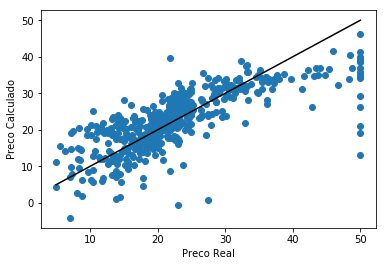

In [51]:
# In[7]:
scatterPlot(y, p)

## 3. Regressão LASSO

Utilizaremos a técnica *Least Absolute Shrinkage and Selection Operator - LASSO* para selecionar as variáveis explicativas utilizando um parâmetro de regularização $\alpha = 0.13$.

### 3.1 LASSO: Ajustando o Modelo 

In [52]:
# ## Regressão LASSO
# 
# In[8]:
from sklearn.linear_model import Lasso

alpha = 0.13

las = Lasso(alpha=alpha)
las.fit(x, y)

# Apresentamos abaixo os coeficientes calculados.
coef_df1 = pd.DataFrame(index=np.append(['Intercept'], boston.feature_names))
coef_df1['LASSO'] = np.append([las.intercept_], las.coef_) 
coef_df1.T

,Intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
LASSO,22.5,-0.537,0.596,-0.0366,0.65,-1.43,2.87,-0,-2.21,0.755,-0.479,-1.88,0.74,-3.73


### 3.2 LASSO: Calculando estatística de ajuste

In [53]:
mse_lasso = mean_squared_error(y, las.predict(x))
r2_lasso = r2_score(y, las.predict(x))

result_df['LASSO'] = [mse_lasso, r2_lasso]
result_df

,OLS,OLS - CV,LASSO
MSE,21.9,37.2,22.7
R²,0.741,0.56,0.732


### 3.3 LASSO: Gráfico Real X Previsto

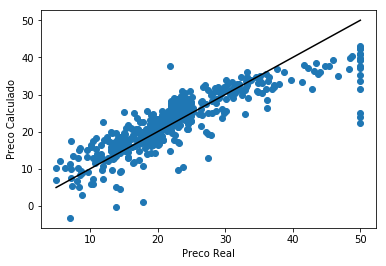

In [54]:
# In[9]:
scatterPlot(y, las.predict(x))

### 3.4 Comparação dos coeficientes: Regressão Linear X LASSO

In [55]:
# Abaixo podemos verificar que, ao penalizar os estimadores com um alpha > 0, quase todos os coeficientes 
#ficaram com valores menores em módulo. O coeficiente de AGE ficou igual a 0, ou seja, o algoritmo eliminou um 
#parâmetro da regressão.

# In[10]:
coef_df['LASSO'] = np.append([las.intercept_], las.coef_) 
coef_df.T

,Intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
OLS,22.5,-0.92,1.08,0.143,0.682,-2.06,2.67,0.0211,-3.1,2.66,-2.08,-2.06,0.857,-3.75
LASSO,22.5,-0.537,0.596,-0.0366,0.65,-1.43,2.87,-0,-2.21,0.755,-0.479,-1.88,0.74,-3.73


### 3.5 LASSO: Validação Cruzada 5-fold

In [56]:
# ## Validação Cruzada - LASSO
# Faremos também um teste de validação cruzada, dividindo os dados em 5 grupos.
# In[11]:
kf = KFold(n_splits=5)
p = np.zeros_like(y)
for k, (train, test) in enumerate(kf.split(x)):
    las.fit(x.loc[train], y[train])
    p[test] = las.predict(x.loc[test])
    print("[Fold {0}] \u03b1: {1:.2f}, R\u00b2: {2:.2f}".
          format(k+1, alpha, las.score(x.loc[test], y[test])))

mse_lasso_cv = mean_squared_error(y, p)
r2_lasso_cv = r2_score(y, p)

result_df['LASSO - CV'] = [mse_lasso_cv, r2_lasso_cv]
result_df

[Fold 1] α: 0.13, R²: 0.69
[Fold 2] α: 0.13, R²: 0.74
[Fold 3] α: 0.13, R²: 0.58
[Fold 4] α: 0.13, R²: 0.06
[Fold 5] α: 0.13, R²: -0.04


,OLS,OLS - CV,LASSO,LASSO - CV
MSE,21.9,37.2,22.7,35.5
R²,0.741,0.56,0.732,0.58


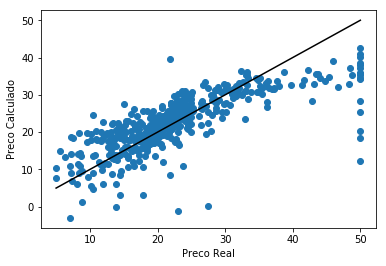

In [57]:
# In[12]:
scatterPlot(y, p)

#### É possível verificar que o R^2 continua baixo para os dois últimos grupos, porém o R^2 geral da validação cruzada foi maior que o da validação cruzada no método de mínimos quadrados ordinários.

### 3.6 LASSO: Comportamento de cada coeficiente da regressão de acordo com a variação do parâmetro de regularização $\alpha$.

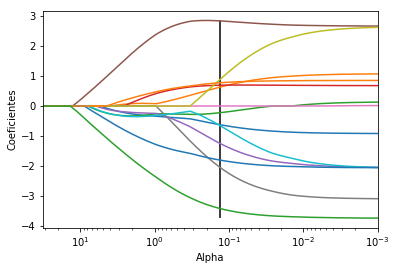

In [58]:
# In[13]:
las = Lasso()
alphas = np.logspace(-3, 1.5, 1000)
alphas, coefs, _ = las.path(x, y, alphas=alphas)

fig, ax = plt.subplots()
ax.plot(alphas, coefs.T)
ax.set_xscale('log')
ax.set_xlim(alphas.max(), alphas.min())
plt.vlines(alpha, coefs.min(), coefs.max())
plt.xlabel("Alpha")
plt.ylabel("Coeficientes")

plt.show()

Quando $\alpha$ é muito grande, a penalização é significativa e todos os coeficientes ficam muito próximos de 0. 
A medida que o $\alpha$ tende a 0, os coeficientes se estabilizam e tendem aos valores calculados pelo método dos mínimos quadrados ordinários.

### 3.7 LASSO: seleção automática do $\alpha$

In [59]:
# Faremos uma implementação de validação cruzada para encontrar o melhor parâmetro de regularização $\alpha$ de 
#acordo com os dados da amostra.

# In[14]:
from sklearn.linear_model import LassoCV

las = LassoCV()
kf = KFold(n_splits=5)
p = np.zeros_like(y)

for k, (train, test) in enumerate(kf.split(x)):
    las.fit(x.loc[train], y[train])
    p[test] = las.predict(x.loc[test])
    print("[Fold {0}] \u03b1: {1:.2f}, R\u00b2: {2:.2f}".
          format(k+1, las.alpha_, las.score(x.loc[test], y[test])))

mse_lasso_cv_2 = mean_squared_error(y, p)
r2_lasso_cv_2 = r2_score(y, p)

result_df['LASSO - CV (\u03b1 selection)'] = [mse_lasso_cv_2, r2_lasso_cv_2]
result_df

[Fold 1] α: 0.76, R²: 0.73
[Fold 2] α: 0.66, R²: 0.70
[Fold 3] α: 0.67, R²: 0.40
[Fold 4] α: 0.02, R²: 0.08
[Fold 5] α: 0.16, R²: -0.03


,OLS,OLS - CV,LASSO,LASSO - CV,LASSO - CV (α selection)
MSE,21.9,37.2,22.7,35.5,38.6
R²,0.741,0.56,0.732,0.58,0.542


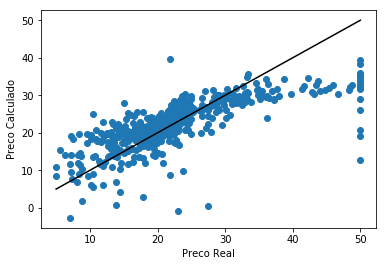

In [60]:
# In[15]:

scatterPlot(y, p)

## 4. Regressão Ridge

Utilizaremos a técnica Ridge com parâmetro de regularização $\alpha = 0.13$ para ajustar um modelo de regressão

### 4.1 Ridge: Ajustando o Modelo 

In [61]:
# ## Regressão Ridge
# 
# In[8]:
from sklearn.linear_model import Ridge

alpha = 5

rdg = Ridge(alpha=alpha)
rdg.fit(x, y)

# Apresentamos abaixo os coeficientes calculados.
coef_df2 = pd.DataFrame(index=np.append(['Intercept'], boston.feature_names))
coef_df2['RIDGE'] = np.append([rdg.intercept_], rdg.coef_) 
coef_df2.T

,Intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
RIDGE,22.5,-0.883,1.01,0.0386,0.697,-1.93,2.71,-0.00781,-2.98,2.34,-1.78,-2.02,0.854,-3.69


### 4.2 Ridge: Calculando estatística de ajuste

In [62]:
mse_ridge = mean_squared_error(y, rdg.predict(x))
r2_ridge = r2_score(y, rdg.predict(x))

result_df['RIDGE'] = [mse_ridge, r2_ridge]
result_df

#print(mse_ridge,r2_ridge)

,OLS,OLS - CV,LASSO,LASSO - CV,LASSO - CV (α selection),RIDGE
MSE,21.9,37.2,22.7,35.5,38.6,21.9
R²,0.741,0.56,0.732,0.58,0.542,0.74


### 4.3 Ridge: Gráfico Real X Previsto

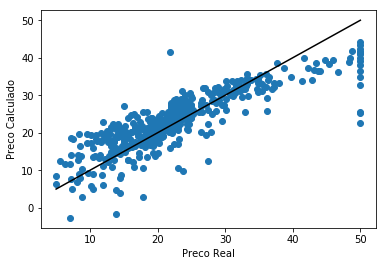

In [63]:
# In[9]:
scatterPlot(y, las.predict(x))

### 4.4 Comparação dos coeficientes: Regressão Linear X LASSO X Ridge

In [64]:
# Abaixo podemos verificar que, ao penalizar os estimadores com um alpha > 0, quase todos os coeficientes 
#ficaram com valores menores em módulo. O coeficiente de AGE ficou igual a 0, ou seja, o algoritmo eliminou um 
#parâmetro da regressão.

# In[10]:
coef_df['RIDGE'] = np.append([rdg.intercept_], rdg.coef_) 
coef_df.T

,Intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
OLS,22.5,-0.92,1.08,0.143,0.682,-2.06,2.67,0.0211,-3.1,2.66,-2.08,-2.06,0.857,-3.75
LASSO,22.5,-0.537,0.596,-0.0366,0.65,-1.43,2.87,-0,-2.21,0.755,-0.479,-1.88,0.74,-3.73
RIDGE,22.5,-0.883,1.01,0.0386,0.697,-1.93,2.71,-0.00781,-2.98,2.34,-1.78,-2.02,0.854,-3.69


### 4.5 Ridge: Validação Cruzada 5-fold

In [65]:
# ## Validação Cruzada - LASSO
# Faremos também um teste de validação cruzada, dividindo os dados em 5 grupos.
# In[11]:
kf = KFold(n_splits=5)
p = np.zeros_like(y)
for k, (train, test) in enumerate(kf.split(x)):
    rdg.fit(x.loc[train], y[train])
    p[test] = rdg.predict(x.loc[test])
    print("[Fold {0}] \u03b1: {1:.2f}, R\u00b2: {2:.2f}".
          format(k+1, alpha, rdg.score(x.loc[test], y[test])))

mse_ridge_cv = mean_squared_error(y, p)
r2_ridge_cv = r2_score(y, p)

result_df['RIDGE - CV'] = [mse_ridge_cv, r2_ridge_cv]
result_df

[Fold 1] α: 5.00, R²: 0.66
[Fold 2] α: 5.00, R²: 0.73
[Fold 3] α: 5.00, R²: 0.59
[Fold 4] α: 5.00, R²: 0.09
[Fold 5] α: 5.00, R²: -0.15


,OLS,OLS - CV,LASSO,LASSO - CV,LASSO - CV (α selection),RIDGE,RIDGE - CV
MSE,21.9,37.2,22.7,35.5,38.6,21.9,35.9
R²,0.741,0.56,0.732,0.58,0.542,0.74,0.575


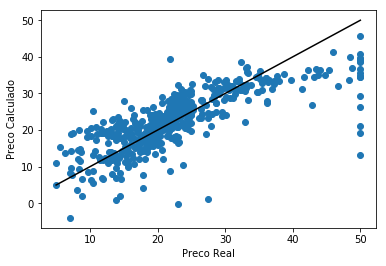

In [66]:
# In[12]:
scatterPlot(y, p)

### 4.6 Ridge: Comportamento de cada coeficiente da regressão de acordo com a variação do parâmetro de regularização $\alpha$.

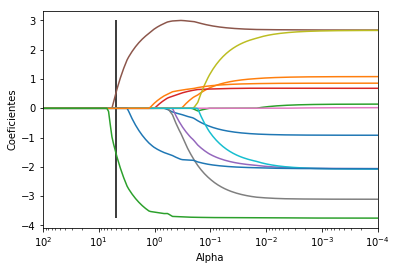

In [67]:
# In[13]:
rdg = Ridge()
alphas = np.logspace(-4, 2, 200)
alphas, coefs, _ = las.path(x, y, alphas=alphas)

fig, ax = plt.subplots()
ax.plot(alphas, coefs.T)
ax.set_xscale('log')
ax.set_xlim(alphas.max(), alphas.min())
plt.vlines(alpha, coefs.min(), coefs.max())
plt.xlabel("Alpha")
plt.ylabel("Coeficientes")

plt.show()

Quando $\alpha$ é muito grande, a penalização é significativa e todos os coeficientes ficam muito próximos de 0. 
A medida que o $\alpha$ tende a 0, os coeficientes se estabilizam e tendem aos valores calculados pelo método dos mínimos quadrados ordinários.

### Conclusão: <br><br> Apesar de termos um ajuste pior da amostra de treino utilizando LASSO, o modelo se comporta melhor nos dados fora da amostra.

Referência
http://prorum.com/index.php/2541/como-implementar-algoritmo-lasso-em-python-compara-lo-ao-ols